Importing Libraries

In [541]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA

from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit import Aer, execute
from qiskit_machine_learning.kernels import QuantumKernel

Importing the Dataset

In [542]:
columns = ["sepal-length", "sepal-width", "petal-length", "petal-width", "class"]
df = pd.read_csv("iris.data", names = columns)

df.head()

,sepal-length,sepal-width,petal-length,petal-width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Scaling the Data between -pi and pi for the Quantum Kernel

In [543]:
scaler = MinMaxScaler(feature_range = (-np.pi, np.pi))

X = df.drop('class', axis = 1).copy()
X = scaler.fit_transform(X)
y = np.array(df['class'].copy())

In [544]:
#pca = PCA(n_components=2)
#X = pca.fit_transform(X)

Creating Training and Testing Datasets

In [545]:
X_train=(np.concatenate((X[0:40], X[50:90], X[100:140]), axis=0))
y_train=np.concatenate((y[0:40], y[50:90], y[100:140]), axis=0)
X_test=np.concatenate((X[40:50], X[90:100], X[140:150]), axis=0)
y_test=np.concatenate((y[40:50], y[90:100], y[140:150]), axis=0)

Creating the Kernel using Pauli Gates

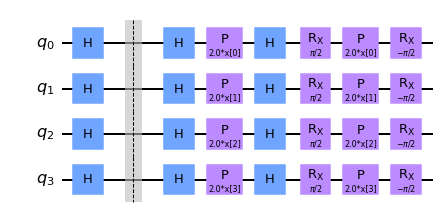

In [546]:
map_feature = PauliFeatureMap(feature_dimension=4, reps=1, paulis=['X', 'Y'], insert_barriers=True)
map_feature.decompose().draw('mpl')

The UU^t format to check overlap (for 2 example features)

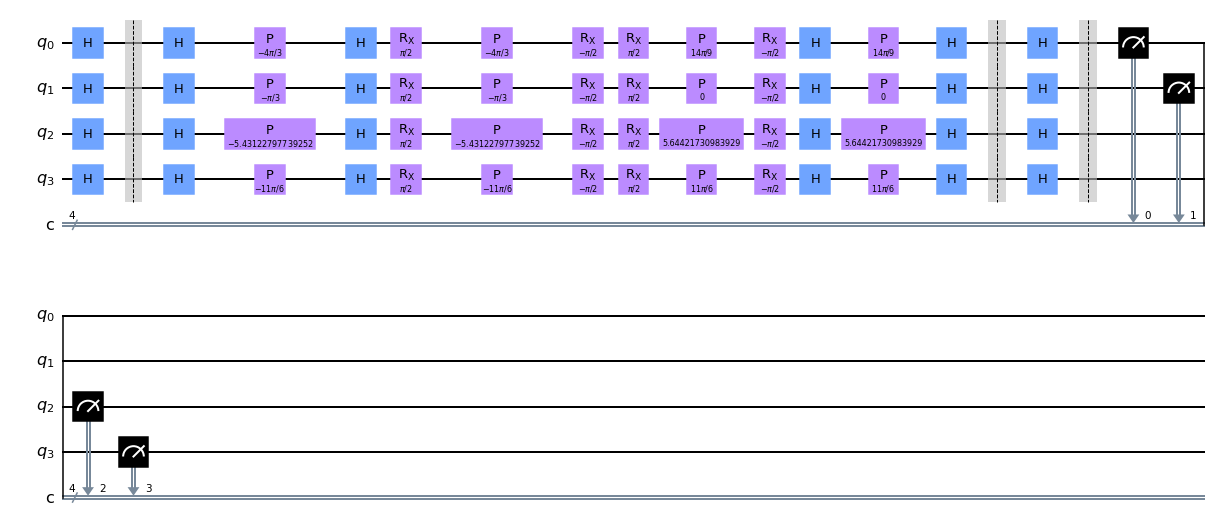

In [547]:
kernel = QuantumKernel(feature_map = map_feature, quantum_instance = Aer.get_backend('statevector_simulator'))
kernel_circuit = kernel.construct_circuit(X[1], X[2])
kernel_circuit.decompose().decompose().draw('mpl')

Computing the Kernel Matrices

In [549]:
train = kernel.evaluate(x_vec = X_train)
test = kernel.evaluate(x_vec = X_test, y_vec = X_train)

Plotting the Kernel Matrices

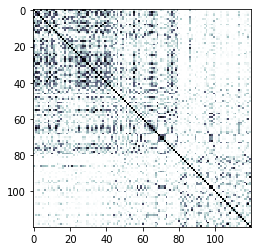

In [550]:
plt.imshow(np.asmatrix(train),interpolation='nearest',origin='upper',cmap='bone_r')

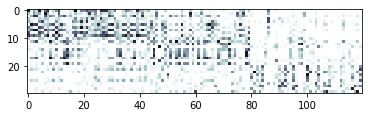

In [551]:
plt.imshow(np.asmatrix(test),interpolation='nearest',origin='upper',cmap='bone_r')

Implementing One vs All SVM

In [552]:
y_train_is = np.zeros(len(y_train), dtype = int)
y_test_is = np.zeros(len(y_test), dtype = int)

for i, y in enumerate(y_train):
    if(y=='Iris-setosa'):
        y_train_is[i] = 1

for i, y in enumerate(y_test):
    if(y=='Iris-setosa'):
        y_test_is[i] = 1

In [553]:
svc_is = SVC(kernel = 'precomputed')
svc_is.fit(train, y_train_is)
svc_is.score(test, y_test_is)

0.9333333333333333

In [554]:
y_train_ivc = np.zeros(len(y_train), dtype = int)
y_test_ivc = np.zeros(len(y_test), dtype = int)

for i, y in enumerate(y_train):
    if(y=='Iris-versicolor'):
        y_train_ivc[i] = 1

for i, y in enumerate(y_test):
    if(y=='Iris-versicolor'):
        y_test_ivc[i] = 1

In [555]:
svc_ivc = SVC(kernel = 'precomputed')
svc_ivc.fit(train, y_train_ivc)
svc_ivc.score(test, y_test_ivc)

0.9666666666666667

In [556]:
y_train_ivg = np.zeros(len(y_train), dtype = int)
y_test_ivg = np.zeros(len(y_test), dtype = int)

for i, y in enumerate(y_train):
    if(y=='Iris-virginica'):
        y_train_ivg[i] = 1

for i, y in enumerate(y_test):
    if(y=='Iris-virginica'):
        y_test_ivg[i] = 1

In [557]:
svc_ivg = SVC(kernel = 'precomputed')
svc_ivg.fit(train, y_train_ivg)
svc_ivg.score(test, y_test_ivg)

1.0

Checking Predictions and Plotting the Confusion Matrix

In [558]:
svc = [svc_is, svc_ivc, svc_ivg]

predict_is = svc_is.predict(test)
predict_ivc = svc_ivc.predict(test)
predict_ivg = svc_ivg.predict(test)

predict = [predict_is, predict_ivc, predict_ivg]
actual = []
prediction = []

for i in range(30):
    a = predict[0][i]
    b = predict[1][i]
    c = predict[2][i]

    if(y_test[i]=='Iris-setosa'):
        actual.append(0)
    elif(y_test[i]=="Iris-versicolor"):
        actual.append(1)
    else:
        actual.append(2)

    if(a>b)and(a>c):
        prediction.append(0)
    elif(b>a)and(b>c):
        prediction.append(1)
    elif(c>a)and(c>b):
        prediction.append(2)
    else:
        prediction.append(3)
    print(a,b,c)

1 0 0
0 0 0
1 0 0
0 0 0
1 0 0
1 0 0
1 0 0
1 0 0
1 0 0
1 0 0
0 1 0
0 1 0
0 1 0
0 1 0
0 1 0
0 1 0
0 1 0
0 1 0
0 0 0
0 1 0
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1
0 0 1


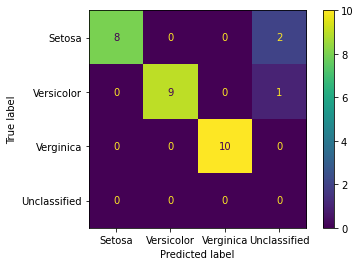

In [559]:
labels = []

cm = confusion_matrix(actual, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Setosa', 'Versicolor', 'Verginica', 'Unclassified'])
disp.plot()